In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import tqdm.notebook as tqdm
import tensorflow as tf
import tensorflow.keras as keras

import lib_stylegan

In [2]:
dataset = lib_stylegan.dataset.train_dataset("data/aligned-dogs-face/*.jpg", batch_size=2, im_size=256)

Number of train images found: 29741


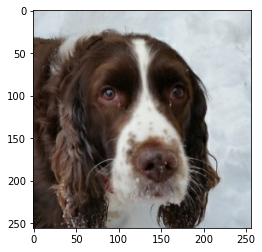

In [3]:
for im in dataset.take(1):
    plt.imshow(im[0])

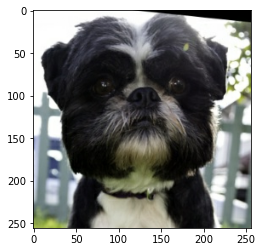

In [4]:
plt.imshow(im[1])

In [5]:
model = lib_stylegan.style_gan.StyleGan(im_size=256, 
                                        latent_size=512, 
                                        channels=32,
                                        nb_style_mapper_layer=6)
model.compile()
#model.fit(dataset.take(16))
model.load_weights("samples/model_small_lr_009")

In [6]:
class Encoder:
    def __init__(self, model, noise="random", loss="L1"):
        self.model = model
        vgg = keras.applications.VGG16(weights='imagenet', include_top=False) #used in the LPIPS distance
        self.vgg = keras.models.Model(vgg.input, vgg.layers[-2].output)
        self.learning_rates = [(1000,0.1), (3000,0.01), (1000,0.001)]
        self.noise_choice = noise
        self.loss_choice = loss
    
    def get_noise(self, batch_size):
        if self.noise_choice == "random":
            noise = []
            for i in range(self.model.n_layers):
                noise_size = self.model.im_size // (2**(self.model.n_layers-i-1))
                noise.append(tf.random.uniform((batch_size,noise_size,noise_size,1)))
            return noise
        return self.noise
    
    def loss(self, generated_images, true_images):
        if self.loss_choice == "L1":
            return tf.reduce_mean(tf.abs(generated_images-true_images))
        elif self.loss_choice == "L2":
            diff = generated_images-true_images
            return tf.reduce_mean(tf.abs(diff*diff))
        elif self.loss_choice == "mixt" :            
            diff = generated_images-true_images
            return self._LPIPS(generated_images, true_images) + 0.2*tf.reduce_mean(tf.abs(diff*diff))
        else :
            assert self.loss_choice == "LPIPS"
            return self._LPIPS(generated_images, true_images)
        
    def _initialization(self):
        """
            compute mu_w and sigma_w that will be usefull for initialization of w
        """
        print("Initializing the latent vector...")
        z = tf.random.normal((1000, 512))
        mu_w = tf.reduce_mean(model.M(z),axis=0)
        return mu_w
    
    def _LPIPS(self, result, target):
        """
            Compute the LPIPS distance between two images.
            result : (btach_size, im_size, im_size, 3)
            target : (btach_size, im_size, im_size, 3)
            
        """
        features_res = self.vgg(result)
        features_tar = self.vgg(target)
        
        diff = features_res - features_tar
        return tf.reduce_mean(diff*diff)

    @tf.function
    def _opt_step(self):
        noise = self.get_noise(tf.shape(self.w_list)[0]) 
        with tf.GradientTape() as g:
            generated_images = self.model.G([self.seed, 1*self.w_list , noise])
            loss = self.loss(generated_images, self.targets)
            diff = self.mu_w - tf.stack(self.w_list, axis=0)
            regularized_loss = tf.reduce_mean(diff*diff)
            total_loss = loss + 0.01*regularized_loss 
        grads = g.gradient(total_loss, self.variables_to_train)
        self.opt.apply_gradients(zip(grads, self.variables_to_train))
        return loss,regularized_loss
            
    def encode_images(self, targets):
        self.targets = tf.cast(targets, dtype=tf.float32)
        #Initialize variables
        self.mu_w = self._initialization()
        w = tf.stack(targets.shape[0]*[self.mu_w], axis=0)
        self.w_list = tf.repeat(w[:,tf.newaxis,:], self.model.n_layers,axis=1)
        self.seed = self.model.S(self.w_list)
        self.w_list = tf.Variable(self.w_list)
        
        if self.noise_choice != "random":
            noise = tf.random.uniform((targets.shape[0], self.model.im_size, self.model.im_size, 1))
            self.noise = tf.Variable(noise)

        self.opt = tf.keras.optimizers.Adam(learning_rate=0.01)
        self.variables_to_train = [self.w_list]
        if self.noise_choice == "trainable":
            self.variables_to_train.append(self.noise)
        
        loss_hist = []
        regularized_loss_hist = []
        for nb_steps, lr in self.learning_rates:
            print(f"Learning rate: {lr}")
            self.opt.lr.assign(lr)
            for k in tqdm.tqdm(range(nb_steps)):
                loss, r_loss = self._opt_step()
                loss_hist.append(loss.numpy())
                regularized_loss_hist.append(r_loss.numpy())
        return loss_hist, regularized_loss_hist, self.w_list, self.get_noise(targets.shape[0])
    
encoder = Encoder(model, loss="mixt")
loss_hist, r_loss_hist, w_list, noise = encoder.encode_images(im)

Initializing the latent vector...
Learning rate: 0.1



Learning rate: 0.01



Learning rate: 0.001


In [16]:
def commput_Lij(nij):
    cor_y = tf.reduce_sum(nij[:,:-1] * nij[:,1:])
    cor_x = tf.reduce_sum(nij[:,:,:-1] * nij[:,:,1:])
    cor_y_wrap = tf.reduce_sum(nij[:,-1]*nij[:,0])
    cor_x_wrap = tf.reduce_sum(nij[:,:,-1]*nij[:,:,0])
    noise_res = nij.shape[2]
    return (cor_y + cor_x + cor_y_wrap + cor_x_wrap) / (noise_res*noise_res)

def regularisation_loss(noise_list, alpha=1e5):
    Lij_sum = 0.
    for ni in noise_list:
        noise_res = ni.shape[1]
        nij = ni
        j = 0
        while noise_res // (2**j) >= 4:
            Lij = commput_Lij(nij)
            Lij_sum = Lij_sum + Lij
            j+=1
            new_res = noise_res // (2**j)
            nij = tf.image.resize(nij, (new_res,new_res)) # default methode is bilinear, not sure if best
    return alpha*Lij_sum

In [7]:
def generate(w_list, noise):
    seed = model.S(1*w_list)
    generated_images = model.G([seed, 1*w_list , noise])
    return generated_images

In [8]:
generated_images = generate(w_list, noise)

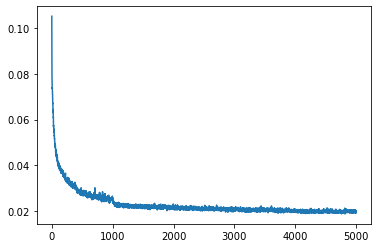

In [9]:
plt.plot(loss_hist)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


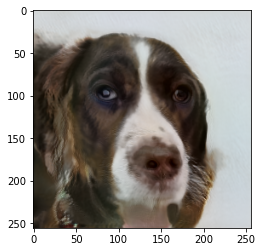

In [10]:
plt.imshow(generated_images[0])

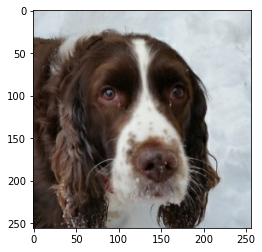

In [11]:
plt.imshow(im[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


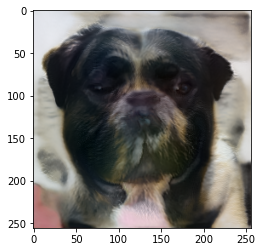

In [12]:
plt.imshow(generated_images[1])

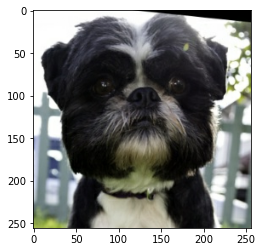

In [13]:
plt.imshow(im[1])